In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import networkx as nx

In [78]:
class MPNNConv(MessagePassing):
    def __init__(self, node_features, edge_features, hidden_features):
        super(MPNNConv, self).__init__(aggr="add")
        self.node_mlp = nn.Sequential(
            nn.Linear(node_features + edge_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, node_features),  # 出力を入力と同じ次元に
        )

    def forward(self, x, edge_index, edge_attr):
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        return self.node_mlp(torch.cat([x_j, edge_attr], dim=1))

    def update(self, aggr_out, x):
        return aggr_out  # 単純な合計を返す

In [79]:
class MPNN(nn.Module):
    def __init__(self, node_features, edge_features, hidden_features):
        super(MPNN, self).__init__()
        self.conv = MPNNConv(node_features, edge_features, hidden_features)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        return self.conv(x, edge_index, edge_attr)

In [80]:
num_nodes = 5
edge_index = torch.tensor(
    [[0, 0, 0, 0, 1, 2, 3, 4], [1, 2, 3, 4, 0, 0, 0, 0]], dtype=torch.long
)
x = torch.tensor([[6.0], [1.0], [1.0], [1.0], [1.0]], dtype=torch.float)  # C=6, H=1
edge_attr = torch.tensor(
    [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]], dtype=torch.float
)

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [81]:
node_features = 1
edge_features = 1
hidden_features = 5
model = MPNN(node_features, edge_features, hidden_features)

In [98]:
import networkx as nx
import matplotlib.pyplot as plt
import torch


def visualize_graph_with_messages(x, edge_index, edge_attr, model, step):
    G = nx.Graph()
    G.add_edges_from(edge_index.t().tolist())
    pos = nx.spring_layout(G)

    plt.figure(figsize=(4, 4))
    nx.draw(
        G,
        pos,
        with_labels=False,
        node_color="lightblue",
        node_size=3000,
        font_size=16,
        font_weight="bold",
    )

    node_labels = {i: f"Node {i}\n{x[i,0]:.2f}" for i in range(x.shape[0])}
    nx.draw_networkx_labels(G, pos, node_labels)

    # メッセージと更新後の値を計算
    with torch.no_grad():
        # モデルのforward passを使用してメッセージを計算
        updated_x = model(Data(x=x, edge_index=edge_index, edge_attr=edge_attr))

        # エッジごとのメッセージを計算
        messages = model.conv.message(x[edge_index[0]], edge_attr)

    # エッジのメッセージを表示
    edge_labels = {}
    for i, (source, target) in enumerate(edge_index.t()):
        edge_labels[(source.item(), target.item())] = f"M: {messages[i, 0]:.2f}"
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # 更新情報を表示
    for i in range(x.shape[0]):
        plt.annotate(
            f"Update: {x[i,0]:.2f} → {updated_x[i,0]:.2f}",
            xy=pos[i],
            xytext=(0, 40),
            textcoords="offset points",
            ha="center",
            va="bottom",
            bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.5),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"),
        )

    plt.title(f"Step {step}: Message Passing Visualization")
    plt.text(0.5, -0.1, "M: Message value", transform=plt.gca().transAxes, ha="center")
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_14165/785510993.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


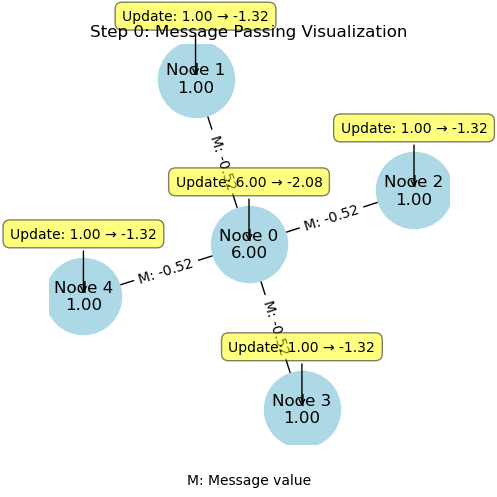

In [99]:
visualize_graph_with_messages(x, edge_index, edge_attr, model, step=0)